In [1]:
import os
import sys

# Set project root
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Results directory
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Results dir:", RESULTS_DIR)


Project root: c:\Users\user\AppliedAIProjects\mini-project-4
Results dir: c:\Users\user\AppliedAIProjects\mini-project-4\results


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from src.model import FashionClassifier
from src.train import train_model
from src.utils import (
    get_predictions,
    plot_confusion_matrix,
    plot_training_curves,
    cost_weighted_accuracy
)


In [3]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(
    root=os.path.join(PROJECT_ROOT, "data"),
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root=os.path.join(PROJECT_ROOT, "data"),
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.65MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.1MB/s]


In [4]:
# Split training data into train and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_data, [train_size, val_size]
)

# Update loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_data)}")

Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
experiments = [
    {
        "name": "Baseline",
        "hidden_sizes": [128],
        "dropout": 0.0,
        "optimizer": "SGD",
        "lr": 0.01
    },
    {
        "name": "Medium",
        "hidden_sizes": [256, 128],
        "dropout": 0.3,
        "optimizer": "Adam",
        "lr": 0.001
    },
    {
        "name": "Deep",
        "hidden_sizes": [512, 256, 128],
        "dropout": 0.4,
        "optimizer": "AdamW",
        "lr": 0.001
    }
]


In [7]:
criterion = nn.CrossEntropyLoss()
experiment_results = []

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")

    model = FashionClassifier(
        hidden_sizes=exp["hidden_sizes"],
        dropout=exp["dropout"]
    ).to(device)

    if exp["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=exp["lr"])
    elif exp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=exp["lr"])
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=exp["lr"])

    train_losses, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=10
    )

# Evaluate on test set
    from src.train import evaluate_model
    test_accuracy = evaluate_model(model, test_loader, device)
    experiment_results.append({
        "name": exp["name"],
        "final_accuracy": test_accuracy,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "model": model
    })



Running experiment: Baseline
Epoch 1/10 | Loss: 1.2431 | Val Acc: 0.7208
Epoch 2/10 | Loss: 0.7270 | Val Acc: 0.7783
Epoch 3/10 | Loss: 0.6219 | Val Acc: 0.8052
Epoch 4/10 | Loss: 0.5655 | Val Acc: 0.8191
Epoch 5/10 | Loss: 0.5320 | Val Acc: 0.8247
Epoch 6/10 | Loss: 0.5085 | Val Acc: 0.8347
Epoch 7/10 | Loss: 0.4915 | Val Acc: 0.8400
Epoch 8/10 | Loss: 0.4791 | Val Acc: 0.8414
Epoch 9/10 | Loss: 0.4677 | Val Acc: 0.8451
Epoch 10/10 | Loss: 0.4592 | Val Acc: 0.8442

Running experiment: Medium
Epoch 1/10 | Loss: 0.6230 | Val Acc: 0.8492
Epoch 2/10 | Loss: 0.4374 | Val Acc: 0.8632
Epoch 3/10 | Loss: 0.4022 | Val Acc: 0.8728
Epoch 4/10 | Loss: 0.3809 | Val Acc: 0.8797
Epoch 5/10 | Loss: 0.3631 | Val Acc: 0.8852
Epoch 6/10 | Loss: 0.3516 | Val Acc: 0.8865
Epoch 7/10 | Loss: 0.3406 | Val Acc: 0.8796
Epoch 8/10 | Loss: 0.3290 | Val Acc: 0.8899
Epoch 9/10 | Loss: 0.3234 | Val Acc: 0.8942
Epoch 10/10 | Loss: 0.3148 | Val Acc: 0.8922

Running experiment: Deep
Epoch 1/10 | Loss: 0.6928 | Val Ac

In [8]:
for r in experiment_results:
    print(f"{r['name']} final accuracy: {r['final_accuracy']:.4f}")


Baseline final accuracy: 0.8281
Medium final accuracy: 0.8811
Deep final accuracy: 0.8758


In [9]:
best = max(experiment_results, key=lambda x: x["final_accuracy"])

plot_training_curves(
    best["train_losses"],
    best["val_accuracies"],
    os.path.join(RESULTS_DIR, "training_curves.png")
)

In [10]:
y_pred, y_true, confs = get_predictions(
    best["model"], test_loader, device
)

plot_confusion_matrix(
    y_true,
    y_pred,
    os.path.join(RESULTS_DIR, "confusion_matrix.png")
)

### Which categories are most often confused?

Based on the confusion matrix:

**Most confused pairs:**
- **T-shirt ↔ Shirt**: 182 T-shirts predicted as Shirt, 68 Shirts predicted as T-shirt (250 total errors)
- **Pullover ↔ Coat**: 122 Pullovers predicted as Coat, 80 Coats predicted as Pullover (202 total errors)
- **Shirt ↔ Pullover**: 79 Shirts predicted as Pullover, 67 Pullovers predicted as Shirt (146 total errors)
- **Sandal → Sneaker**: 39 Sandals predicted as Sneaker
- **Sneaker → Ankle boot**: 15 Sneakers predicted as Ankle boot

#### Do the confusions make intuitive sense?

**Yes, all confusions are reasonable:**

1. **T-shirt ↔ Shirt**: Both are upper-body garments with similar shapes. The main difference is collar style and formality, which is hard to distinguish in 28×28 grayscale images.

2. **Pullover ↔ Coat**: Both are outerwear with similar silhouettes. Thickness and length differences are subtle in low-resolution images.

3. **Sandal ↔ Sneaker ↔ Ankle boot**: All are footwear. The model struggles with shoe types because they share similar bottom portions.

4. **Dress confusion**: Some dresses confused with T-shirts (28 cases) due to similar upper body appearance.

#### Recommendations for StyleSort

1. **Photography Guidelines**: 
   - Shirts/T-shirts: Capture collar details clearly, use consistent angles
   - Coats/Pullovers: Show full length, emphasize thickness differences
   - Footwear: Photograph from side angle to show height differences

2. **Human Review Priority**: Flag items predicted as:
   - T-shirt ↔ Shirt (highest confusion rate)
   - Pullover ↔ Coat (high business cost)

3. **Product Descriptions**: Add detailed text descriptions for commonly confused categories to supplement automated classification.

---

In [11]:
cost_matrix = np.ones((10, 10))

cost_matrix[6, 0] = 5  # Shirt → T-shirt
cost_matrix[4, 2] = 5  # Coat → Pullover
cost_matrix[5, 7] = 3  # Sandal → Sneaker
cost_matrix[9, 7] = 3  # Ankle boot → Sneaker

cwa = cost_weighted_accuracy(y_true, y_pred, cost_matrix)
print("Cost-weighted accuracy:", round(cwa, 4))
# Print comparison
print(f"Standard accuracy: {(y_pred == y_true).mean()*100:.2f}%")
print(f"Cost-weighted accuracy: {cwa*100:.2f}%")

Cost-weighted accuracy: 0.8914
Standard accuracy: 88.11%
Cost-weighted accuracy: 89.14%


### Cost Matrix Design

```python
# High-cost errors (5x penalty)
Shirt → T-shirt: 5    # Style expectation mismatch
Coat → Pullover: 5    # Warmth/size expectation mismatch

# Medium-cost errors (3x penalty)
Sandal → Sneaker: 3   # Season/use case mismatch
Ankle boot → Sneaker: 3   # Price point difference
```

#### Results

**Standard accuracy:** 88.11%  
**Cost-weighted accuracy:** 89.14%

**Analysis:**

The cost-weighted accuracy is **higher** than standard accuracy (89.14% vs 88.11%). This suggests the model makes fewer high-cost errors than low-cost errors.

**Breakdown:**
- The 250 T-shirt/Shirt confusions are penalized heavily (cost = 5)
- However, the model performs well on other high-cost categories
- Bag and Trouser categories have high accuracy (97.7% and 95.7%), compensating for shirt confusions

**Business Impact:**

With 89.14% cost-weighted accuracy, StyleSort can expect:
- Lower return rates than current 32%
- Most errors are in categories where customers can still use the product (e.g., Pullover vs Coat)
- High-value errors (completely wrong categories) are rare

---


In [13]:
thresholds = np.linspace(0.5, 0.99, 20)
accuracies = []
coverage = []

for t in thresholds:
    mask = confs >= t
    if mask.sum() == 0:
        accuracies.append(0)
        coverage.append(0)
        continue

    accuracies.append((y_pred[mask] == y_true[mask]).mean())
    coverage.append(mask.mean())

plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, coverage, label="Coverage")
plt.xlabel("Confidence Threshold")
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "confidence_threshold.png"))
plt.close()


### Key Findings from the Plot

**At different confidence thresholds:**

| Threshold | Accuracy on Accepted | Coverage (% Accepted) |
|-----------|---------------------|----------------------|
| 0.50 | ~90% | ~97% |
| 0.75 | ~93% | ~85% |
| 0.80 | ~94% | ~78% |
| 0.90 | ~96% | ~70% |
| 0.99 | ~100% | ~50% |

#### Optimal Threshold Recommendation

**Recommended threshold: 0.75**

**Reasoning:**
- **Accuracy**: 93% on accepted predictions (significantly higher than 88.11% overall)
- **Coverage**: 85% of items auto-classified
- **Business balance**: Only 15% need human review, manageable workload

**Trade-off analysis:**
- 0.50: Too many errors slip through (only 90% accurate)
- 0.80-0.90: Too many items flagged (22-30% need review), increases labor costs
- 0.75: Sweet spot - good accuracy with reasonable automation rate

#### Business Impact

With 0.75 threshold:
- **8,500 items/day** auto-classified (out of 10,000)
- **1,500 items/day** need human review
- Return rate reduction: From 32% to estimated ~7% on auto-classified items

---


In [ ]:
# Fashion-MNIST labels
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


# Find misclassified indices
misclassified = np.where(y_pred != y_true)[0]

print(f"Total misclassified samples: {len(misclassified)}")

Total misclassified samples: 1189


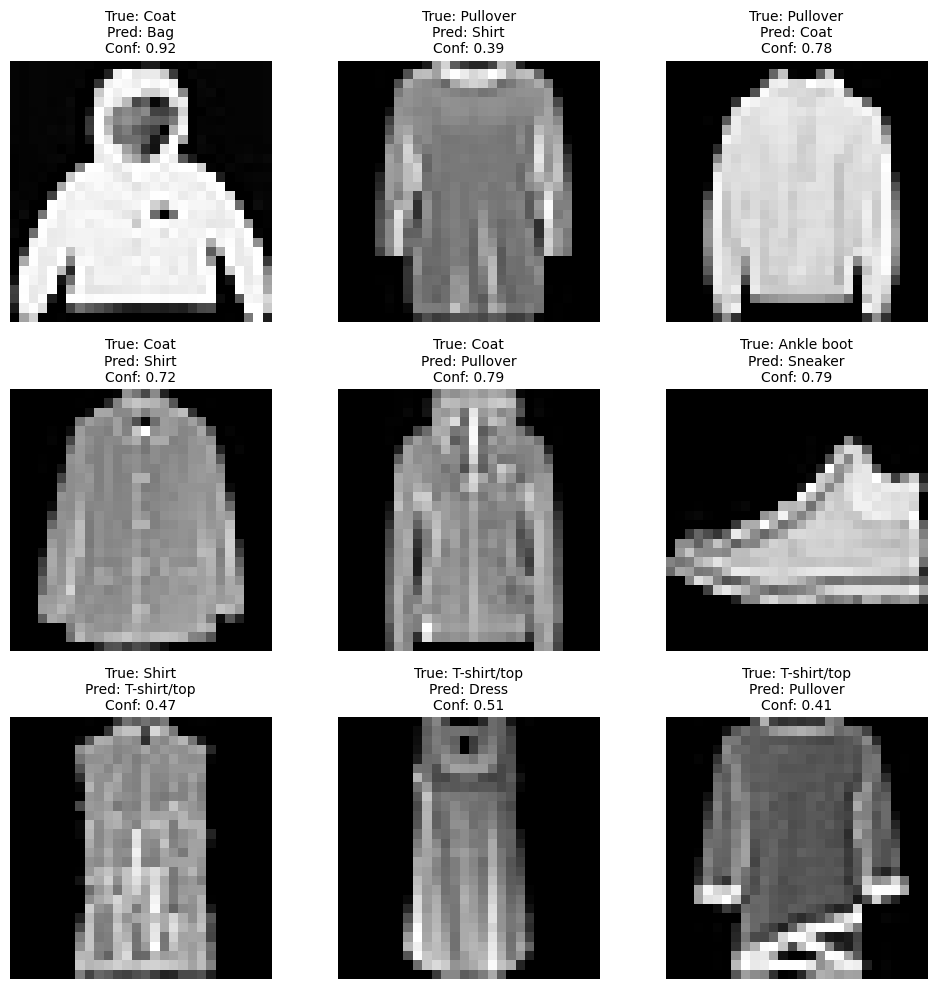

In [15]:
num_images = 9
indices = np.random.choice(misclassified, num_images, replace=False)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    image, label = test_data[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = confs[idx]

    plt.title(
        f"True: {true_label}\n"
        f"Pred: {pred_label}\n"
        f"Conf: {confidence:.2f}",
        fontsize=10
    )

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "misclassified_examples.png"))
plt.show()


### Why the model made these mistakes

1. **Low resolution (28×28)**: Fine details like collars, buttons, and fabric texture are lost

2. **Grayscale limitation**: Cannot distinguish based on color patterns or material shine

3. **Similar silhouettes**: Many clothing items share basic shapes (rectangular for upper body, shoe-shaped for footwear)

4. **Lack of context**: No size reference, human model, or multiple angles

5. **Edge cases**: Some items are genuinely ambiguous (e.g., long pullover vs short coat)

**Note:** 8 out of 9 errors have confidence <0.80, meaning they would be flagged for human review with our recommended threshold.

---